# Transmission Contribution Visuals - WIP
## NEED TO FIX PHOTOMETRIC

In this notebook, we will cover how to analyze 

1. The spectral components of a transmission spectrum 
2. Where in the forward model atmosphere the spectrum is forming 
3. Which wavelength regions are probing which pressure regions

We will be using HD 189733b as an example planet.

Lets define the planet with a nominal chemical chemical inventory

['CH4', 'CO', 'CO2', 'HCN', 'H2O','K','Na','NH3']

As well as an aerosol that is predicted to form at the limb of HD 189733b from GCM chemical disequilibrium predictions, enstatite (MgSiO3)

['MgSiO3']

In [3]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, load_data, define_model, \
                          wl_grid_constant_R, set_priors, read_opacities
from POSEIDON.visuals import plot_data, plot_spectra_retrieved, plot_PT_retrieved
from POSEIDON.retrieval import run_retrieval
from POSEIDON.utility import read_retrieved_spectrum, read_retrieved_PT, \
                             read_retrieved_log_X, plot_collection
from POSEIDON.corner import generate_cornerplot

import numpy as np
from scipy.constants import au
from scipy.constants import parsec as pc

do_retrieval = True

#***** Model wavelength grid *****#

wl_min = 0.2    # Minimum wavelength (um)
wl_max = 12     # Maximum wavelength (um)
R = 1000       # Spectral resolution of grid

# Doing a linear spacing in UV to cut down computation time
wl_1 = np.linspace(wl_min, 1.0, 1000)[:-1]
wl_2 = wl_grid_constant_R(1.0, wl_max, R)
wl_2 = wl_2[1:]    # Indexing to avoid 1.0 um being repeated twice
wl = np.concatenate((wl_1, wl_2))

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7109*pc # Distance to system (m)
#d_err = 0.005*pc # Error in a priori system distance
a_p = 0.03142*au

# Create the planet object
# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p)

#***** Define stellar properties *****#

R_s = 0.751*R_Sun      # Stellar radius (m)
T_s = 5052         # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

#***** Specify data location and instruments *****#

model_name_contribution_transmission = 'Contribution-Transmission'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = ['CH4', 'CO', 'CO2', 'HCN', 'H2O','K','Na','NH3']
aerosol_species = ['MgSiO3']

# Create the model object
model_contribution_transission = define_model(model_name_contribution_transmission,
                                               bulk_species, param_species, 
                                               PT_profile = 'isotherm',
                                               cloud_model = 'Mie',cloud_type = 'slab',
                                               aerosol_species = aerosol_species)

Reading in database for aerosol cross sections...


Load in opac

In [4]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 500    # Same as prior range for T
T_fine_max = 1300    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-8   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1 

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_contribution_transission, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CH4 done
CO done
CO2 done
HCN done
H2O done
K done
Na done
NH3 done
Opacity pre-interpolation complete.


Define model parameters and make atmosphere object

In [5]:
R_p_ref                =   1.126 * R_J

T                      =   775.1
log_CH4                =   -8.56
log_CO                 =   -6.74
log_CO2                =   -6.90
log_HCN                =   -5.04
log_H2O                =   -3.94
log_K                  =   -8.85
log_Na                 =   -9.69
log_NH3                =   -9.08

log_P_top_slab_MgSiO3 =   -7.22
Delta_log_P_MgSiO3    =   2.97
log_r_m_MgSiO3        =   -1.34
log_X_MgSiO3          =   -12

from POSEIDON.core import make_atmosphere

PT_params = np.array([T])
log_X_params = np.array([log_CH4, log_CO, log_CO2, log_HCN, log_H2O, log_K, log_Na, log_NH3])
cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Make atmosphere 
atmosphere_contribution_transission = make_atmosphere(planet, model_contribution_transission, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

# Now lets produce a spectral contribution plot 

The spectral contribution function (spectral_contribuion()) found in contributions.py helps visualize the spectral components of specific species and their contribution to the spectrum. 

The function first computes all the hydrostatic equations assuming all the species are in the atmosphere. It then remove all the opacities of the species except for the one whose contribution is being visualized. (This function utlizes the 'put-one-in' approach of visualization)

In the function, you list out which gas species you want in the contribution_species_list

You then can list out cloud_species_list if you are using compositionally specific aerosols (also need to set cloud_contribution = True)

If you are not, you can set cloud_total_contribution = True to see the contribution of opaque decks, hazes, and the combined cloud opacity of combined clouds models. 

If you want to see the baseline contiuum opacity, set bulk species = True. 

The function returns the full spectrum (spectrum), the names of each spectrum computed, and the list of contribution spectra.

In [6]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_contribution_transission, atmosphere_contribution_transission, opac, wl,
                                                                                            contribution_species_list = ['CH4', 'CO', 'CO2', 'HCN', 'H2O', 'K', 'Na', 'NH3'],
                                                                                            cloud_species_list = ['MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, )

To plot, use the plot_spectral_contribution() function

In this function, you can define the line widths as well as colors

We reccomend the full spectrum being a large line width, and then then the contribution spectra being smaller so that they can be seen overlaying the full spectrum. 

Below, we can see that H2O, HCN, CO2, and MgSiO3 contribute the most to the spectrum

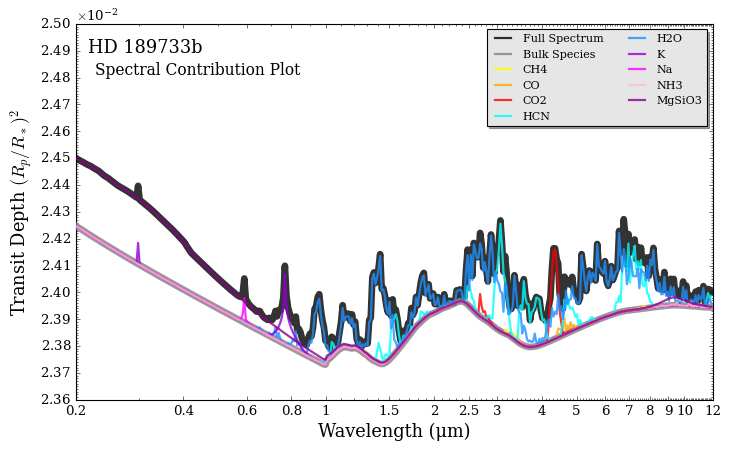

<Figure size 853.36x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

fig_combined = plt.figure(constrained_layout=True, figsize=(9, 5.5))    # Change (9,5.5) to alter the aspect ratio

# This function is the magic. Each letter corresponds to one matplotlib axis, which you can then pass to POSEIDON's plotting functions
axd = fig_combined.subplot_mosaic(
    """
    AAAA
    AAAA
    """
)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2,2,2,2,2,2],
                           colour_list = ['black', 'gray', 'yellow','orange', 'red', 'aqua', 'dodgerblue',
                                          'darkviolet','magenta','pink','limegreen'],
                            ax = axd['A']
                            )

# Pressure Contribution

The pressure contribution function goes layer by layer, removes an opacity source, and recomputes the spectrum, and takes the difference with the full spectrum. 

There is an option to do the total pressure contribution (which removes each layers entire opacity source) or specific opacity sources.

Do note, however, that this process is very slow, but very useful for analyzing which pressures in the forward model the spectrum is probing. We reccomend setting the spectral resolution to R = 1000 and remaking the opac object before running the following code.

We compute the total pressure contribution and water's pressure contribution below.

Since this is transmission, we expect all the contribution to be coming from high up in the atmosphere. 

To create the pressure contribution, run the pressure_contribution() function below, which has has a similar set up to the spectral contribution funciton above. Here we have verbose turned on, which prints the layer number the function is on (the Pressure array has 100 layers), which is a good gauge for how long the spectrum will take to compute.

Contribution is an array with dimensions P vs wl vs contribution species. The norm is returned, but not used. The list names is used in plotting.

The plotting functions will return a normal contribution plot, and then a log version.

Lets look at the total pressure contribution first

In [8]:
from POSEIDON.contributions import pressure_contribution, plot_pressure_contribution

Contribution, norm,  spectrum_contribution_list_names = pressure_contribution(planet, star, model_contribution_transission, atmosphere_contribution_transission, opac, wl,
                                            spectrum_type = 'transmission',
                                            bulk_species = False, 
                                            cloud_contribution = False, 
                                            total_pressure_contribution=True,
                                            verbose = True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


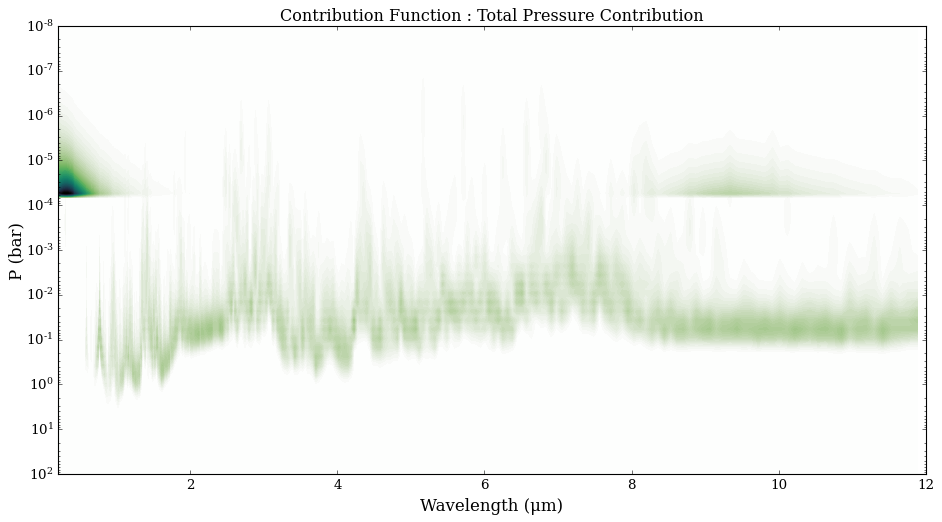

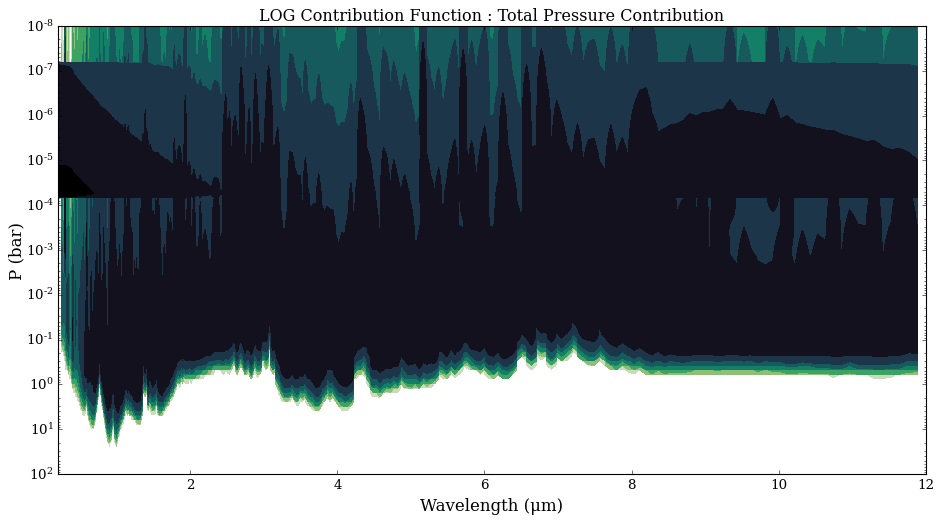

In [9]:
plot_pressure_contribution(wl,P,Contribution, spectrum_contribution_list_names, R = 100) 

Now lets just look at water 

In [11]:
from POSEIDON.contributions import pressure_contribution, plot_pressure_contribution

Contribution_water, norm_water,  spectrum_contribution_list_names_water = pressure_contribution(planet, star, model_contribution_transission, atmosphere_contribution_transission, opac, wl,
                                            spectrum_type = 'transmission',
                                            contribution_species_list = ['H2O'],
                                            bulk_species = False, 
                                            cloud_contribution = False, 
                                            total_pressure_contribution=False,
                                            verbose = True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


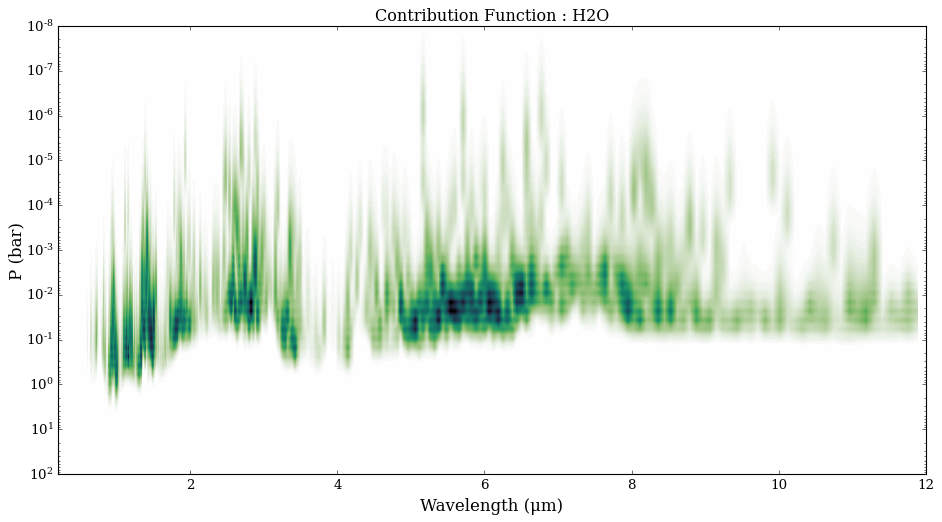

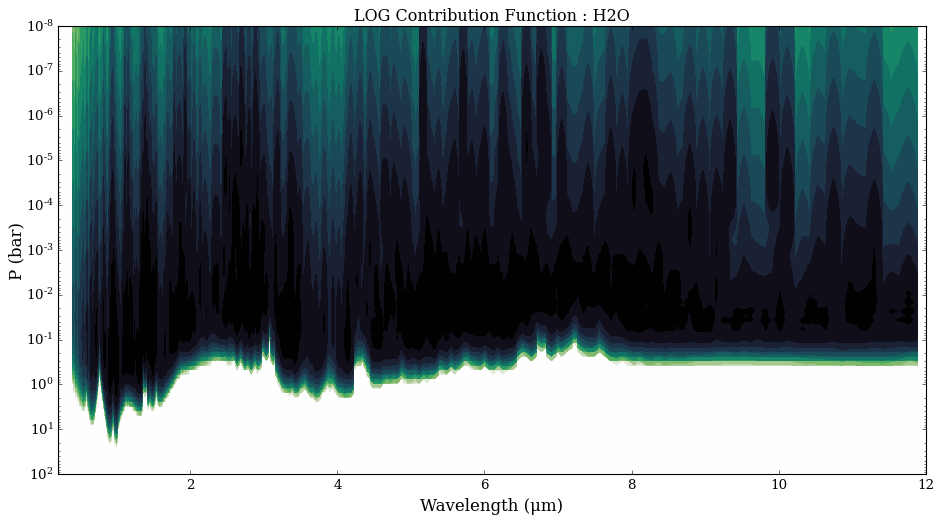

In [13]:
plot_pressure_contribution(wl,P,Contribution_water, spectrum_contribution_list_names_water, R = 100) 

# Photometric Contribution 

The pressure contribution function can also be integrated over a specific wavelength range to produce a `photometric' pressure contribution function. 

We recommend wavelength bins of size $\Delta \lambda = 1$   um, to show which pressure layers contribute most over a given wavelength range.

THe plotting function beow will plot the binned contributions, then the total over all wavelengths.

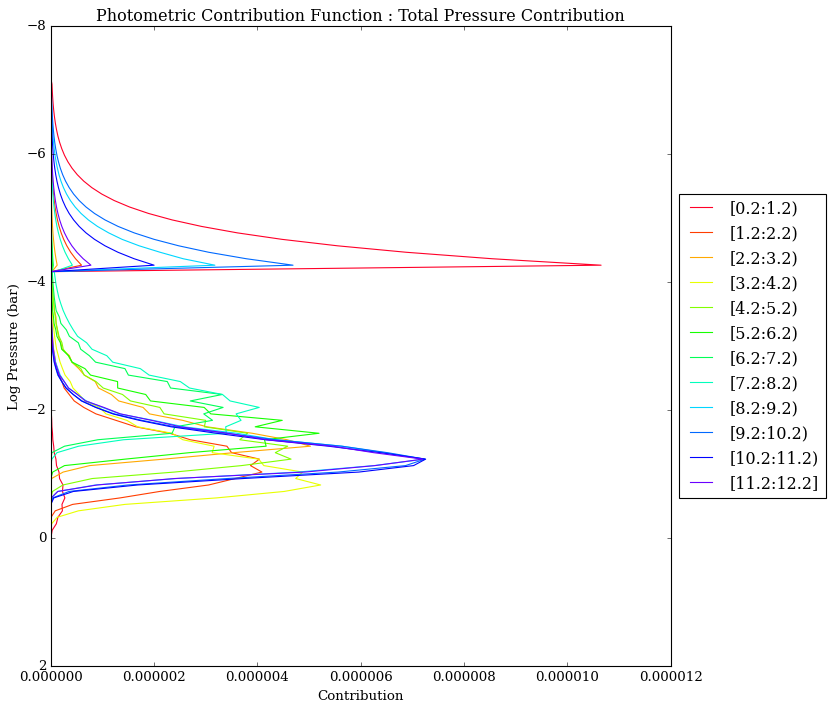

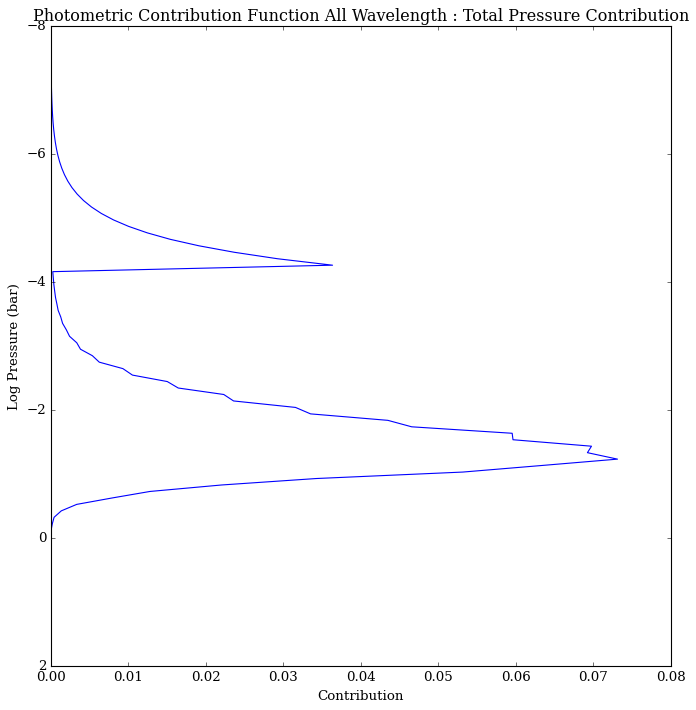

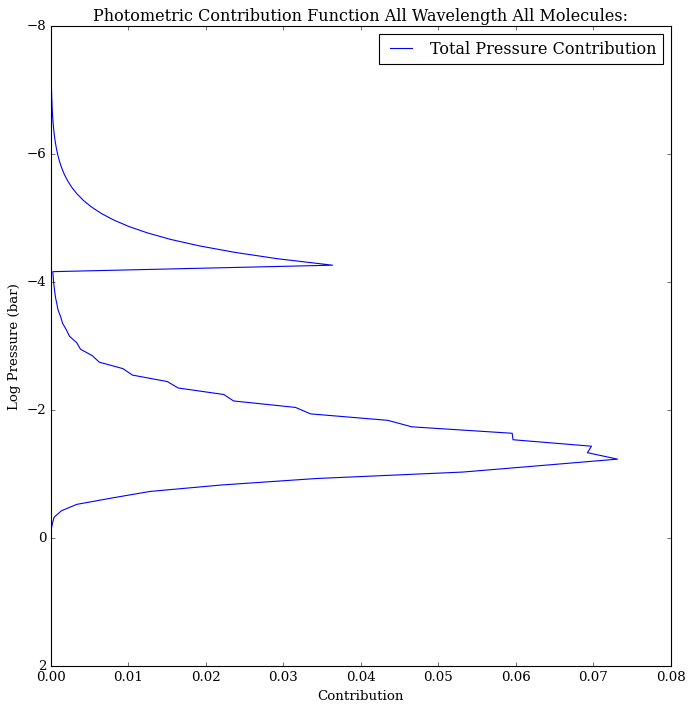

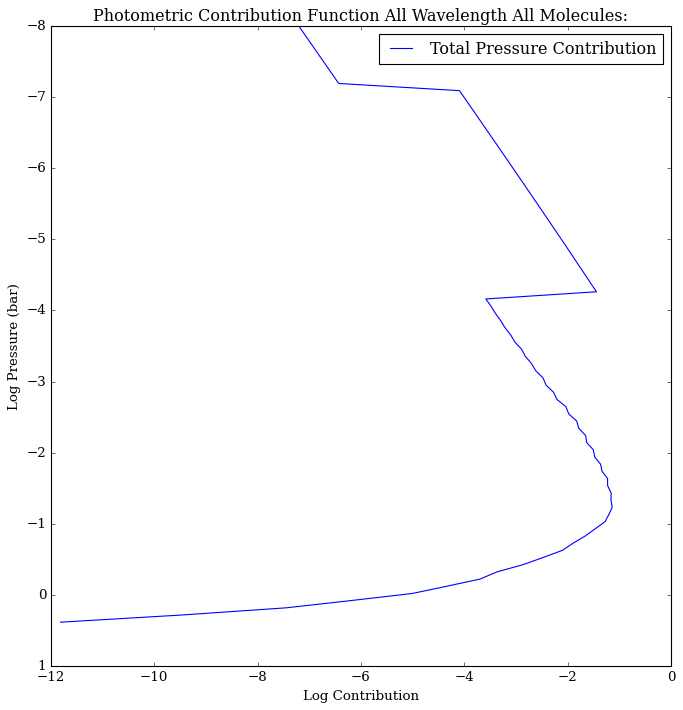

In [19]:
from POSEIDON.contributions import photometric_contribution_function, plot_photometric_contribution

photometric_contribution, photometric_total, bins = photometric_contribution_function(wl, P, Contribution, 
                                                                                spectrum_contribution_list_names,
                                                                                binsize = 1)

plot_photometric_contribution(wl,P,
                                  photometric_contribution, photometric_total,
                                  spectrum_contribution_list_names,
                                  bins = bins)

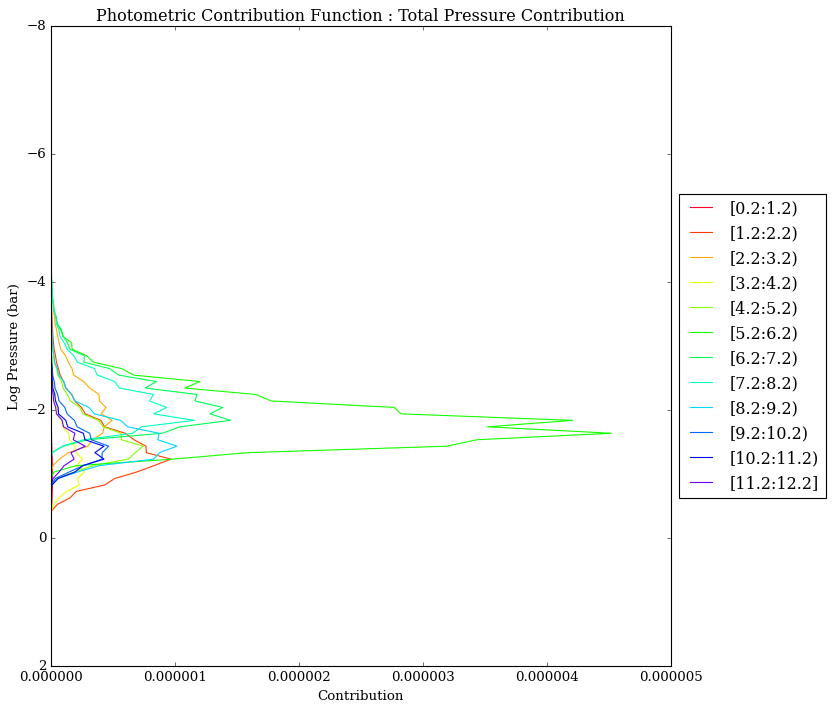

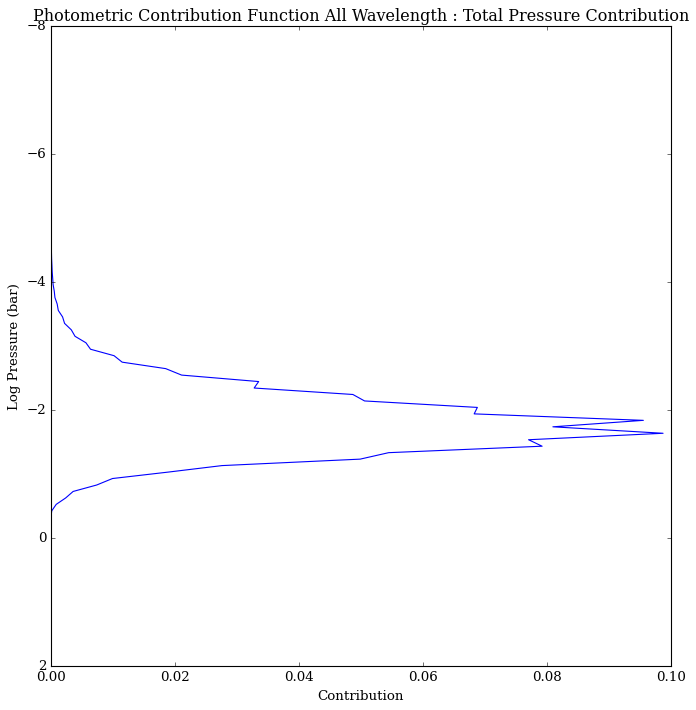

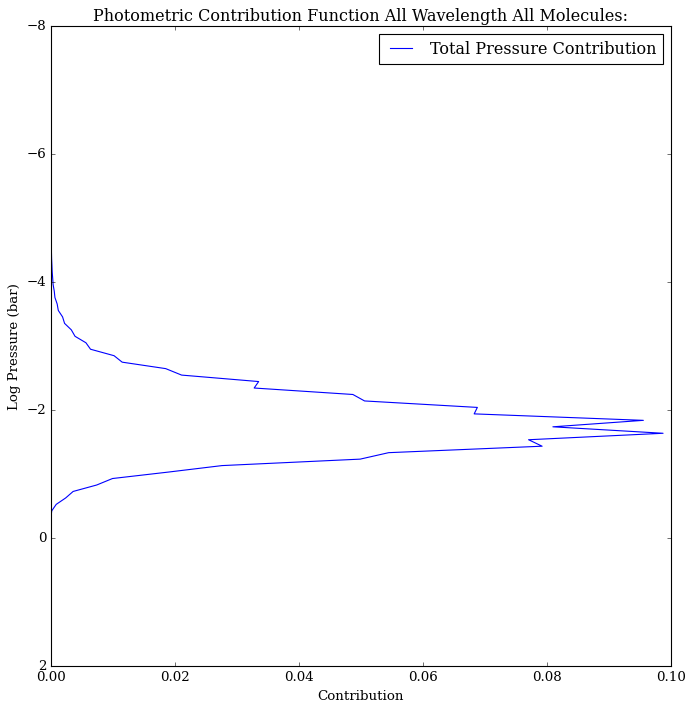

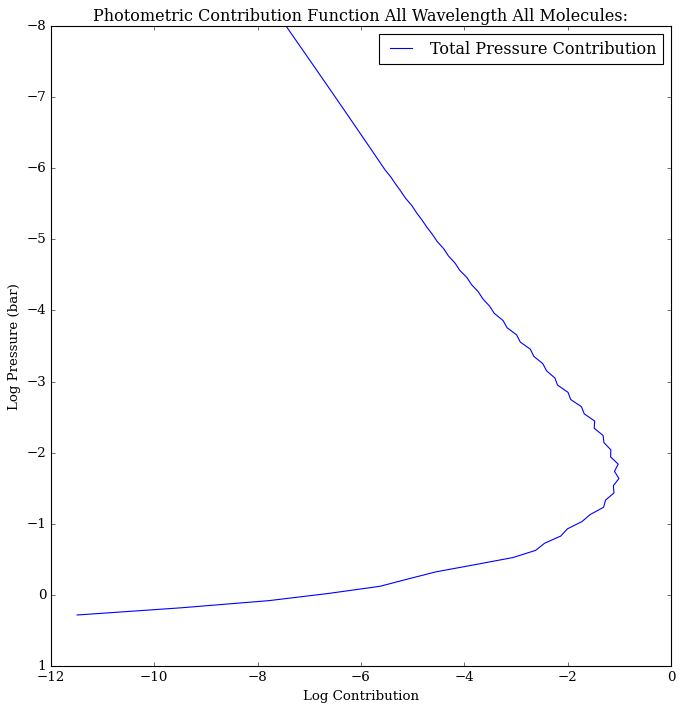

In [20]:
from POSEIDON.contributions import photometric_contribution_function, plot_photometric_contribution

photometric_contribution, photometric_total, bins = photometric_contribution_function(wl, P, Contribution_water, 
                                                                                spectrum_contribution_list_names_water,
                                                                                binsize = 1)

plot_photometric_contribution(wl,P,
                                  photometric_contribution, photometric_total,
                                  spectrum_contribution_list_names,
                                  bins = bins)